In [1]:
import numpy as np
import pandas as pd

In [2]:
iris = pd.read_csv('iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
X = iris.drop('species',axis=1)
y = iris['species']
y.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [4]:
from sklearn.preprocessing import LabelBinarizer

In [5]:
encoder = LabelBinarizer()
y = encoder.fit_transform(y)
print(y[:5]) #one-hot encoded

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]]


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test  = scaler.transform(X_test)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [10]:
model = Sequential()
model.add(Dense(units=4,activation='relu',input_shape=[4,])) #4 features
model.add(Dense(units=3,activation='softmax')) 
#between three classes choose one, therefore softmax (multi-class classification)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
early_stop = EarlyStopping(patience=10)
model.fit(x=scaled_X_train, 
          y=y_train, 
          epochs=400,
          validation_data=(scaled_X_test, y_test), verbose=0 ,callbacks=[early_stop] )

In [13]:
metrics = pd.DataFrame(model.history.history)
metrics.head()

,loss,accuracy,val_loss,val_accuracy
0,1.284351,0.133333,1.299760,0.0
1,1.273459,0.016667,1.286899,0.0
2,1.262296,0.008333,1.275145,0.0
3,1.252813,0.000000,1.263580,0.0
4,1.243119,0.000000,1.253134,0.0


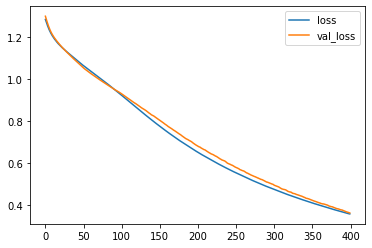

In [14]:
metrics[['loss','val_loss']].plot()

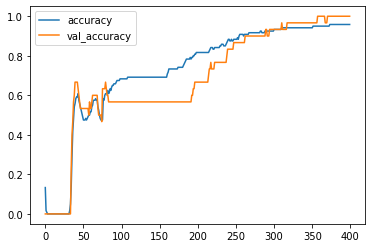

In [15]:
metrics[['accuracy','val_accuracy']].plot()

In [16]:
model.evaluate(scaled_X_test,y_test,verbose=0)

[0.3607468008995056, 1.0]

Deployment

In [17]:
epochs = len(metrics)
#for deployment retrain ALL DATA, both test and train
scaled_X = scaler.fit_transform(X)

In [18]:
model = Sequential()
model.add(Dense(units=4,activation='relu'))

# Last layer for multi-class classification of 3 species
model.add(Dense(units=3,activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
model.fit(scaled_X,y,epochs=epochs,verbose=1)

Epoch 1/400
5/5 [==============================] - 0s 3ms/step - loss: 1.2999 - accuracy: 0.0067
Epoch 2/400
5/5 [==============================] - 0s 4ms/step - loss: 1.2897 - accuracy: 0.0000e+00
Epoch 3/400
5/5 [==============================] - 0s 3ms/step - loss: 1.2796 - accuracy: 0.0067
Epoch 4/400
5/5 [==============================] - 0s 4ms/step - loss: 1.2696 - accuracy: 0.0000e+00
Epoch 5/400
5/5 [==============================] - 0s 3ms/step - loss: 1.2602 - accuracy: 0.0000e+00
Epoch 6/400
5/5 [==============================] - 0s 4ms/step - loss: 1.2507 - accuracy: 0.0000e+00
Epoch 7/400
5/5 [==============================] - 0s 3ms/step - loss: 1.2423 - accuracy: 0.0000e+00
Epoch 8/400
5/5 [==============================] - 0s 3ms/step - loss: 1.2340 - accuracy: 0.0000e+00
Epoch 9/400
5/5 [==============================] - 0s 3ms/step - loss: 1.2251 - accuracy: 0.0000e+00
Epoch 10/400
5/5 [==============================] - 0s 4ms/step - loss: 1.2178 - accuracy: 0.0000e+

In [20]:
model.save("final_iris_model.h5")

In [21]:
import joblib

In [22]:
joblib.dump(scaler,'iris_scaler.pkl')

['iris_scaler.pkl']

In [23]:
from tensorflow.keras.models import load_model

In [27]:
flower_model = load_model("final_iris_model.h5")
flower_scaler = joblib.load("iris_scaler.pkl") #scaler object

In [28]:
iris.head(1)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa


In [29]:
flower_example = {'sepal_length':5.1,
                 'sepal_width':3.5,
                 'petal_length':1.4,
                 'petal_width':0.2}

In [30]:
flower_example.keys()

dict_keys(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])

In [31]:
encoder.classes_

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [32]:
def return_prediction(model,scaler,sample_json):
     
    s_len = sample_json['sepal_length']
    s_wid = sample_json['sepal_width']
    p_len = sample_json['petal_length']
    p_wid = sample_json['petal_width']
    
    flower = [[s_len,s_wid,p_len,p_wid]]
    
    flower = scaler.transform(flower)
    
    classes = np.array(['setosa', 'versicolor', 'virginica'])
    
    class_ind = model.predict_classes(flower)
    
    return classes[class_ind][0]

In [33]:
return_prediction(flower_model,flower_scaler,flower_example)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'setosa'

Code to deploy online

In [37]:
from tensorflow.keras.models import load_model
import joblib
import numpy as np

flower_model = load_model("final_iris_model.h5")
flower_scaler = joblib.load("iris_scaler.pkl")


def return_prediction(model,scaler,sample_json):
    
    # For larger data features, you should probably write a for loop
    # That builds out this array for you
    
    s_len = sample_json['sepal_length']
    s_wid = sample_json['sepal_width']
    p_len = sample_json['petal_length']
    p_wid = sample_json['petal_width']
    
    flower = [[s_len,s_wid,p_len,p_wid]]
    
    flower = scaler.transform(flower)
    
    classes = np.array(['setosa', 'versicolor', 'virginica'])
    
    class_ind = model.predict_classes(flower)
    
    return classes[class_ind][0]

In [38]:
flower_example = {
"sepal_length":5.1,
"sepal_width":3.5,
"petal_length":1.4,
"petal_width":0.2
}